In [4]:
import numpy as np
import matplotlib.pyplot as plt
#import mpl_stylesheet

#mpl_stylesheet.banskt_presentation(fontfamily = 'system')

In [5]:
### Simulation of data

def simulate(sb, sx):
    ngene = 1000
    nsample = 338
    nsnp = sx.shape[0]
    
    betas = np.random.normal(0, sb, ngene)
    Y = np.zeros((ngene, nsample))
    for i in range(ngene):
        Y[i, :] = np.random.normal(0, 1, nsample)

    Y = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    yTbeta = np.dot(Y.T, betas)
    X = np.zeros((nsnp, nsample))
    for i in range(nsnp):
        error = np.random.normal(0, sx[i], nsample)
        X[i, :] = yTbeta + error
    return X, Y

In [6]:
def logml(X, Y, sb, sx):
    nsnp = X.shape[0]
    nsample = X.shape[1]
    sb2 = sb * sb
    sx2 = np.square(sx)
    
    Yt = Y.T # shape N x G
    Abase = sb2 * np.dot(Yt, Yt.T)    
    totres = 0
    for i in range(nsnp):
        A = Abase.copy()
        A[np.diag_indices(nsample)] += sx2[i]
        logdetA = np.linalg.slogdet(A)
        invA = np.linalg.inv(A)
        res = - 0.5 * ( nsample * np.log(2 * np.pi) + logdetA[1] + np.dot(X[i, :].T, np.dot(invA, X[i, :])) )
        totres += res
    return totres

def logml_alt_svd(X, Y, sb, sx):
    nsnp = X.shape[0]
    ngene = Y.shape[0]
    sb2 = sb * sb
    sx2 = np.square(sx)   
    
    Yt = Y.T # shape N x G
    Abase = np.dot(Yt.T, Yt)
    totres = 0
    for i in range(nsnp):
        A = Abase.copy()
        A[np.diag_indices(ngene)] += sx2[i] / sb2
        logdetA = np.linalg.slogdet(A)
        U, S, Vt = np.linalg.svd(Yt)
        Smod = np.diag(np.square(S) / (np.square(S) + sx2[i] / sb2))
        W = np.dot(U, np.dot(Smod, U.T))
        partres = - 0.5 * ngene * np.log(2 * np.pi * sb2) - 0.5 * logdetA[1]
        totres += partres + 0.5 * np.dot(X[i, :].T, np.dot(W, X[i,:])) / sx2[i]
    return totres

In [17]:
def find_best_sigmabeta(X, Y, sigmabeta):
    #sigmax = np.std(X, axis = 1)
    sigmax = np.std(X - np.mean(X, axis = 0), axis = 1)
    ysimp  = [logml(X, Y, sbeta, sigmax) for sbeta in sigmabeta]
    best_sigmabeta = sigmabeta[ysimp.index(np.max(ysimp))]
    print ("Sigmabeta from optimization: {:g}".format(best_sigmabeta))
    return ysimp, best_sigmabeta

In [18]:
true_sigmabeta = np.logspace(-4, 1, 20)
best_sigmabeta = np.zeros_like(true_sigmabeta)
nsnp = 10
for i, sigmabeta in enumerate(true_sigmabeta):
    sigmax = np.linspace(0, 0.4, nsnp)
    X, Y = simulate(sigmabeta, sigmax)
    print("Sigmabeta true value: {:g}".format(sigmabeta))
    sigmabeta_seq = np.logspace(-5, 2, 40)
    best_sigmabeta[i] = find_best_sigmabeta(X, Y, sigmabeta_seq)[1]

Sigmabeta true value: 0.0001
Sigmabeta from optimization: 1e-05
Sigmabeta true value: 0.000183298
Sigmabeta from optimization: 1e-05
Sigmabeta true value: 0.000335982
Sigmabeta from optimization: 1e-05
Sigmabeta true value: 0.000615848
Sigmabeta from optimization: 1e-05
Sigmabeta true value: 0.00112884
Sigmabeta from optimization: 1e-05
Sigmabeta true value: 0.00206914
Sigmabeta from optimization: 0.000942668
Sigmabeta true value: 0.00379269
Sigmabeta from optimization: 0.00325702
Sigmabeta true value: 0.00695193
Sigmabeta from optimization: 0.0074438
Sigmabeta true value: 0.0127427
Sigmabeta from optimization: 0.0112534
Sigmabeta true value: 0.0233572
Sigmabeta from optimization: 0.0257191
Sigmabeta true value: 0.0428133
Sigmabeta from optimization: 0.0388816
Sigmabeta true value: 0.078476
Sigmabeta from optimization: 0.0888624
Sigmabeta true value: 0.143845
Sigmabeta from optimization: 0.13434
Sigmabeta true value: 0.263665
Sigmabeta from optimization: 0.307029
Sigmabeta true value: 

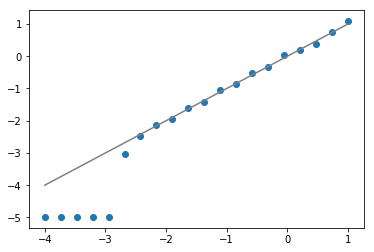

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.log10(true_sigmabeta), np.log10(best_sigmabeta))
ax1.plot(np.log10(true_sigmabeta), np.log10(true_sigmabeta), color='gray')
plt.show()

In [20]:
true_sigmabeta = 0.2
sigmax = np.linspace(0, 0.4, 10)
X, Y = simulate(true_sigmabeta, sigmax)
sigmabeta = np.logspace(-10, 4, 50)
ysimp, best_sigmabeta = find_best_sigmabeta(X, Y, sigmabeta)

Sigmabeta from optimization: 0.26827


True value: -0.69897
Best value: -0.571429


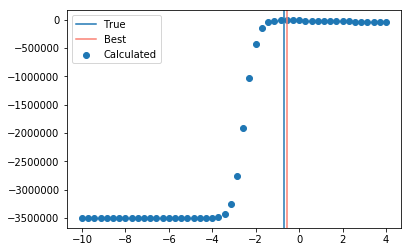

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(np.log10(sigmabeta), ysimp, label = 'Calculated')
ax1.axvline(x = np.log10(true_sigmabeta), label = 'True')
ax1.axvline(x = np.log10(best_sigmabeta), color = 'salmon', label = 'Best')
print("True value: {:g}".format(np.log10(true_sigmabeta)))
print("Best value: {:g}".format(np.log10(best_sigmabeta)))
#ax1.set_ylim([-1200, -1000])

plt.legend(loc = 'upper left')
plt.show()